In [17]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
import optuna
import shap

In [32]:
train = pd.read_csv("C:\\Users\\ERALP\\OneDrive\\Desktop\\Software Engineering\\Kaggle\Kaggle_Challenges\\Titanic - Machine Learning from Disaster\\Kaggle-Titanic\\train.csv")

test = pd.read_csv("C:\\Users\\ERALP\\OneDrive\\Desktop\\Software Engineering\\Kaggle\Kaggle_Challenges\\Titanic - Machine Learning from Disaster\\Kaggle-Titanic\\test.csv")

In [33]:
train.drop(["Name", "Ticket", "Cabin", "Fare"], axis = 1, inplace = True)
survived = train["Survived"]
train.drop(["Survived"], axis = 1, inplace = True)
train["Survived"] = survived

In [34]:
test.drop(["Name", "Ticket", "Cabin", "Fare"], axis = 1, inplace = True)

In [35]:
train.loc[train["Age"].isna(), "Age"] = 0

In [36]:
train.loc[train["Embarked"].isna(), "Embarked"] = 0

In [37]:
test.loc[test["Age"].isna(), "Age"] = 0

In [38]:
X = train.drop(["Survived"], axis=1)


In [39]:
y = train["Survived"].copy()

In [40]:
X_encoded = pd.get_dummies(X, columns=["Pclass","Sex", "Embarked" ])
X_encoded = X_encoded.drop(["Embarked_0"], axis = 1)

In [41]:
Test_encoded = pd.get_dummies(test, columns=["Pclass", "Sex", "Embarked"])

In [42]:
Test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Age          418 non-null    float64
 2   SibSp        418 non-null    int64  
 3   Parch        418 non-null    int64  
 4   Pclass_1     418 non-null    uint8  
 5   Pclass_2     418 non-null    uint8  
 6   Pclass_3     418 non-null    uint8  
 7   Sex_female   418 non-null    uint8  
 8   Sex_male     418 non-null    uint8  
 9   Embarked_C   418 non-null    uint8  
 10  Embarked_Q   418 non-null    uint8  
 11  Embarked_S   418 non-null    uint8  
dtypes: float64(1), int64(3), uint8(8)
memory usage: 16.5 KB


In [43]:
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Age          891 non-null    float64
 2   SibSp        891 non-null    int64  
 3   Parch        891 non-null    int64  
 4   Pclass_1     891 non-null    uint8  
 5   Pclass_2     891 non-null    uint8  
 6   Pclass_3     891 non-null    uint8  
 7   Sex_female   891 non-null    uint8  
 8   Sex_male     891 non-null    uint8  
 9   Embarked_C   891 non-null    uint8  
 10  Embarked_Q   891 non-null    uint8  
 11  Embarked_S   891 non-null    uint8  
dtypes: float64(1), int64(3), uint8(8)
memory usage: 34.9 KB


In [49]:
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size = 0.2, random_state = 42, stratify=y)

In [53]:
clf_xgb = xgb.XGBClassifier(objective = "binary:logistic", random_state = 42)

clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

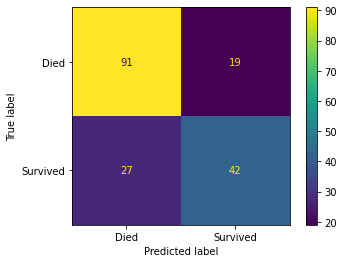

In [54]:
ConfusionMatrixDisplay.from_estimator(clf_xgb, X_val, y_val, display_labels=["Died", "Survived"])

In [55]:
def objective(trial):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_val, label=y_val)

    param = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000, 10),
            'max_depth': trial.suggest_int('max_depth', 3, 9, 1),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 7, 1),
            'subsample': trial.suggest_float('subsample', 0.5, 1),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
            'gamma': trial.suggest_float('gamma', 0, 1, step=0.1),
            'lambda': trial.suggest_float('lambda', 0.5, 1.5),
            'alpha': trial.suggest_float('alpha', 0.5, 1.5)
        }

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_val, pred_labels)

    return accuracy

In [56]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2023-08-11 15:32:59,489] A new study created in memory with name: no-name-05ded701-b8ca-44b9-9b3f-2ca13e1a5f8a
[I 2023-08-11 15:32:59,520] Trial 0 finished with value: 0.7932960893854749 and parameters: {'learning_rate': 0.16276067371947175, 'n_estimators': 300, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.982951346321882, 'colsample_bytree': 0.9794913549465036, 'gamma': 0.9, 'lambda': 1.0362857179291205, 'alpha': 1.335176961785733}. Best is trial 0 with value: 0.7932960893854749.
[I 2023-08-11 15:32:59,611] Trial 1 finished with value: 0.7877094972067039 and parameters: {'learning_rate': 0.18114852027568373, 'n_estimators': 460, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.7572397906760379, 'colsample_bytree': 0.7120301890840499, 'gamma': 0.2, 'lambda': 1.0703291801255865, 'alpha': 0.5695039347986461}. Best is trial 0 with value: 0.7932960893854749.
[I 2023-08-11 15:32:59,627] Trial 2 finished with value: 0.7877094972067039 and parameters: {'learning_rate': 0.1467

[15:32:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:32:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:32:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:32:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:32:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are n

[I 2023-08-11 15:32:59,720] Trial 6 finished with value: 0.7932960893854749 and parameters: {'learning_rate': 0.25309157254261433, 'n_estimators': 710, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.9927000415474623, 'colsample_bytree': 0.5590887898110477, 'gamma': 0.1, 'lambda': 1.2144279430818612, 'alpha': 1.3330604830129622}. Best is trial 0 with value: 0.7932960893854749.
[I 2023-08-11 15:32:59,752] Trial 7 finished with value: 0.7877094972067039 and parameters: {'learning_rate': 0.09284562817463658, 'n_estimators': 620, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.7925937692596097, 'colsample_bytree': 0.5799894979314331, 'gamma': 1.0, 'lambda': 0.9612426954630153, 'alpha': 0.6373342897852553}. Best is trial 0 with value: 0.7932960893854749.
[I 2023-08-11 15:32:59,768] Trial 8 finished with value: 0.7821229050279329 and parameters: {'learning_rate': 0.16209169567582948, 'n_estimators': 120, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.5565148420176065, 'col

[15:32:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:32:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:32:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:32:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:32:59,983] Trial 10 finished with value: 0.7932960893854749 and parameters: {'learning_rate': 0.018442159429600757, 'n_estimators': 420, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8057485624940296, 'colsample_bytree': 0.765063807038157, 'gamma': 0.6000000000000001, 'lambda': 1.4542259182788269, 'alpha': 1.1648256625744313}. Best is trial 9 with value: 0.7988826815642458.
[I 2023-08-11 15:33:00,110] Trial 11 finished with value: 0.7877094972067039 and parameters: {'learning_rate': 0.21623034701578453, 'n_estimators': 290, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.9717531249136148, 'colsample_bytree': 0.9706822681982643, 'gamma': 0.6000000000000001, 'lambda': 1.154065427894609, 'alpha': 1.4795820893626137}. Best is trial 9 with value: 0.7988826815642458.


[15:32:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:00,263] Trial 12 finished with value: 0.8044692737430168 and parameters: {'learning_rate': 0.21708513588757344, 'n_estimators': 310, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8611574697300476, 'colsample_bytree': 0.8917702718346969, 'gamma': 0.8, 'lambda': 0.8620925318522733, 'alpha': 1.4986843013569495}. Best is trial 12 with value: 0.8044692737430168.
[I 2023-08-11 15:33:00,402] Trial 13 finished with value: 0.8100558659217877 and parameters: {'learning_rate': 0.22275454966613095, 'n_estimators': 300, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8647021314323569, 'colsample_bytree': 0.8847076242271602, 'gamma': 0.7000000000000001, 'lambda': 0.8288070901353659, 'alpha': 1.4951766130694515}. Best is trial 13 with value: 0.8100558659217877.


[15:33:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:00,559] Trial 14 finished with value: 0.7988826815642458 and parameters: {'learning_rate': 0.2233487912379733, 'n_estimators': 330, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.8897106410800352, 'colsample_bytree': 0.8855629072130522, 'gamma': 0.8, 'lambda': 0.8133157226502428, 'alpha': 1.4779856440718575}. Best is trial 13 with value: 0.8100558659217877.
[I 2023-08-11 15:33:00,690] Trial 15 finished with value: 0.7821229050279329 and parameters: {'learning_rate': 0.28559905028488536, 'n_estimators': 470, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.8705801643869747, 'colsample_bytree': 0.8948561722176411, 'gamma': 0.7000000000000001, 'lambda': 0.5109128216511329, 'alpha': 1.496266869187604}. Best is trial 13 with value: 0.8100558659217877.


[15:33:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:00,815] Trial 16 finished with value: 0.8044692737430168 and parameters: {'learning_rate': 0.2425991651319498, 'n_estimators': 960, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.8765890201035058, 'colsample_bytree': 0.9061486532856804, 'gamma': 0.4, 'lambda': 0.8560558078575463, 'alpha': 1.2027773759230562}. Best is trial 13 with value: 0.8100558659217877.
[I 2023-08-11 15:33:00,940] Trial 17 finished with value: 0.8100558659217877 and parameters: {'learning_rate': 0.19751243561609935, 'n_estimators': 260, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.9202656957686769, 'colsample_bytree': 0.8303997661291751, 'gamma': 0.8, 'lambda': 0.8012138778681619, 'alpha': 1.0730962085201021}. Best is trial 13 with value: 0.8100558659217877.


[15:33:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:01,066] Trial 18 finished with value: 0.8156424581005587 and parameters: {'learning_rate': 0.19587411496620805, 'n_estimators': 250, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.9256832465614988, 'colsample_bytree': 0.8412799858246098, 'gamma': 0.5, 'lambda': 0.734143338042988, 'alpha': 1.0386395469156244}. Best is trial 18 with value: 0.8156424581005587.
[I 2023-08-11 15:33:01,204] Trial 19 finished with value: 0.776536312849162 and parameters: {'learning_rate': 0.25911566356969296, 'n_estimators': 390, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.9223609846651117, 'colsample_bytree': 0.707703554900375, 'gamma': 0.5, 'lambda': 0.7476959721928652, 'alpha': 0.8708257217955037}. Best is trial 18 with value: 0.8156424581005587.


[15:33:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:01,361] Trial 20 finished with value: 0.7821229050279329 and parameters: {'learning_rate': 0.19278558474198654, 'n_estimators': 210, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.8292431010093233, 'colsample_bytree': 0.936970506622963, 'gamma': 0.5, 'lambda': 0.9621704752654608, 'alpha': 0.8821474746697187}. Best is trial 18 with value: 0.8156424581005587.
[I 2023-08-11 15:33:01,523] Trial 21 finished with value: 0.7932960893854749 and parameters: {'learning_rate': 0.2038348226781815, 'n_estimators': 240, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.9373277943643472, 'colsample_bytree': 0.8194346691148219, 'gamma': 0.7000000000000001, 'lambda': 0.7782152517726454, 'alpha': 1.1006995859696458}. Best is trial 18 with value: 0.8156424581005587.


[15:33:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:01,679] Trial 22 finished with value: 0.8044692737430168 and parameters: {'learning_rate': 0.23022170303710734, 'n_estimators': 550, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.9188421177302865, 'colsample_bytree': 0.84125445190085, 'gamma': 0.7000000000000001, 'lambda': 0.7177340705701446, 'alpha': 1.0547917037169878}. Best is trial 18 with value: 0.8156424581005587.


[15:33:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:01,854] Trial 23 finished with value: 0.8156424581005587 and parameters: {'learning_rate': 0.19280242413899623, 'n_estimators': 240, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.921171149421493, 'colsample_bytree': 0.8468615084576898, 'gamma': 0.8, 'lambda': 0.8858866525212425, 'alpha': 0.9374061735381235}. Best is trial 18 with value: 0.8156424581005587.
[I 2023-08-11 15:33:02,121] Trial 24 finished with value: 0.7932960893854749 and parameters: {'learning_rate': 0.2595012619067149, 'n_estimators': 370, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.8390975730875134, 'colsample_bytree': 0.9349007588027962, 'gamma': 0.4, 'lambda': 0.9233774102792379, 'alpha': 0.9402928725437252}. Best is trial 18 with value: 0.8156424581005587.


[15:33:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:02,309] Trial 25 finished with value: 0.8044692737430168 and parameters: {'learning_rate': 0.18938122227386722, 'n_estimators': 210, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.9568058280698892, 'colsample_bytree': 0.8642821540691646, 'gamma': 0.6000000000000001, 'lambda': 0.8738142775065837, 'alpha': 0.7791372553865017}. Best is trial 18 with value: 0.8156424581005587.
[I 2023-08-11 15:33:02,450] Trial 26 finished with value: 0.7932960893854749 and parameters: {'learning_rate': 0.23112155741406923, 'n_estimators': 520, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.9123145171602655, 'colsample_bytree': 0.7934411670952746, 'gamma': 0.9, 'lambda': 0.7233770127943697, 'alpha': 0.9860528088020982}. Best is trial 18 with value: 0.8156424581005587.


[15:33:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:02,594] Trial 27 finished with value: 0.8044692737430168 and parameters: {'learning_rate': 0.26785153161463615, 'n_estimators': 350, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.9999025222992907, 'colsample_bytree': 0.8628825247501228, 'gamma': 0.5, 'lambda': 0.8223318129662882, 'alpha': 1.265825124231654}. Best is trial 18 with value: 0.8156424581005587.
[I 2023-08-11 15:33:02,733] Trial 28 finished with value: 0.7821229050279329 and parameters: {'learning_rate': 0.24289656326649187, 'n_estimators': 100, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.9465517524800747, 'colsample_bytree': 0.9306552752311972, 'gamma': 0.9, 'lambda': 1.0111470073466033, 'alpha': 1.116163813131195}. Best is trial 18 with value: 0.8156424581005587.


[15:33:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:02,858] Trial 29 finished with value: 0.7988826815642458 and parameters: {'learning_rate': 0.20917047903573013, 'n_estimators': 270, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.8930686213382882, 'colsample_bytree': 0.8073242067237607, 'gamma': 0.4, 'lambda': 0.5858893306797511, 'alpha': 1.3421425671984966}. Best is trial 18 with value: 0.8156424581005587.
[I 2023-08-11 15:33:02,984] Trial 30 finished with value: 0.7877094972067039 and parameters: {'learning_rate': 0.17040795544522724, 'n_estimators': 440, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.961073643422572, 'colsample_bytree': 0.7478079579499581, 'gamma': 0.7000000000000001, 'lambda': 0.7552791894414171, 'alpha': 1.1504810734837903}. Best is trial 18 with value: 0.8156424581005587.


[15:33:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:03,118] Trial 31 finished with value: 0.8156424581005587 and parameters: {'learning_rate': 0.19804133573250188, 'n_estimators': 230, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.9064634794847021, 'colsample_bytree': 0.8318549148144864, 'gamma': 0.8, 'lambda': 0.8000477119174908, 'alpha': 1.0477986072116254}. Best is trial 18 with value: 0.8156424581005587.
[I 2023-08-11 15:33:03,271] Trial 32 finished with value: 0.7988826815642458 and parameters: {'learning_rate': 0.19113732314253243, 'n_estimators': 230, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.857088719668238, 'colsample_bytree': 0.8701128941600003, 'gamma': 0.8, 'lambda': 0.9132124011713367, 'alpha': 1.0374037517809669}. Best is trial 18 with value: 0.8156424581005587.


[15:33:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:03,418] Trial 33 finished with value: 0.8156424581005587 and parameters: {'learning_rate': 0.17276769182787102, 'n_estimators': 180, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.8963549648306924, 'colsample_bytree': 0.843801680052659, 'gamma': 0.6000000000000001, 'lambda': 0.8128647185435912, 'alpha': 1.1296334494894484}. Best is trial 18 with value: 0.8156424581005587.
[I 2023-08-11 15:33:03,543] Trial 34 finished with value: 0.8156424581005587 and parameters: {'learning_rate': 0.18570243632543698, 'n_estimators': 170, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.8969235627003549, 'colsample_bytree': 0.8383446467942394, 'gamma': 0.6000000000000001, 'lambda': 0.7094435491910533, 'alpha': 0.9674807402017727}. Best is trial 18 with value: 0.8156424581005587.


[15:33:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:03,684] Trial 35 finished with value: 0.8156424581005587 and parameters: {'learning_rate': 0.17517572458651862, 'n_estimators': 180, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.9727958736001076, 'colsample_bytree': 0.8098180186070789, 'gamma': 0.30000000000000004, 'lambda': 0.7769430925808766, 'alpha': 1.0901546721020048}. Best is trial 18 with value: 0.8156424581005587.
[I 2023-08-11 15:33:03,842] Trial 36 finished with value: 0.8156424581005587 and parameters: {'learning_rate': 0.14943197188143628, 'n_estimators': 100, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.9408197899300782, 'colsample_bytree': 0.8559111512266336, 'gamma': 0.9, 'lambda': 0.8731047868450729, 'alpha': 1.0338416457250614}. Best is trial 18 with value: 0.8156424581005587.


[15:33:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:03,978] Trial 37 finished with value: 0.8044692737430168 and parameters: {'learning_rate': 0.13930751731499405, 'n_estimators': 770, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.8988303689350456, 'colsample_bytree': 0.7763526692272154, 'gamma': 0.6000000000000001, 'lambda': 0.6812632191500978, 'alpha': 0.929886010712134}. Best is trial 18 with value: 0.8156424581005587.
[I 2023-08-11 15:33:04,124] Trial 38 finished with value: 0.7877094972067039 and parameters: {'learning_rate': 0.17600194266022204, 'n_estimators': 150, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.7468731265680206, 'colsample_bytree': 0.7371021672444211, 'gamma': 1.0, 'lambda': 0.6103810451699846, 'alpha': 1.176802825622491}. Best is trial 18 with value: 0.8156424581005587.


[15:33:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:04,271] Trial 39 finished with value: 0.7932960893854749 and parameters: {'learning_rate': 0.1602904411986662, 'n_estimators': 500, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9731645783991805, 'colsample_bytree': 0.8243916306994246, 'gamma': 0.8, 'lambda': 1.043791774699413, 'alpha': 0.9935248737585622}. Best is trial 18 with value: 0.8156424581005587.
[I 2023-08-11 15:33:04,421] Trial 40 finished with value: 0.8100558659217877 and parameters: {'learning_rate': 0.20213941290826606, 'n_estimators': 390, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.935010601810247, 'colsample_bytree': 0.7904095792586707, 'gamma': 0.30000000000000004, 'lambda': 0.6883332984749938, 'alpha': 1.1311545320934489}. Best is trial 18 with value: 0.8156424581005587.


[15:33:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:04,573] Trial 41 finished with value: 0.8100558659217877 and parameters: {'learning_rate': 0.18406947729086223, 'n_estimators': 200, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.9078294445139385, 'colsample_bytree': 0.8424548300588818, 'gamma': 0.6000000000000001, 'lambda': 0.7199843620671953, 'alpha': 0.9670253779573287}. Best is trial 18 with value: 0.8156424581005587.
[I 2023-08-11 15:33:04,721] Trial 42 finished with value: 0.8100558659217877 and parameters: {'learning_rate': 0.17242785809584057, 'n_estimators': 150, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.8910120432800592, 'colsample_bytree': 0.8445041220108856, 'gamma': 0.5, 'lambda': 0.7530427539808876, 'alpha': 1.048230631697924}. Best is trial 18 with value: 0.8156424581005587.


[15:33:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:04,848] Trial 43 finished with value: 0.8044692737430168 and parameters: {'learning_rate': 0.20085849264984365, 'n_estimators': 140, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9947674717368304, 'colsample_bytree': 0.8043754200380855, 'gamma': 0.4, 'lambda': 0.6604423400523907, 'alpha': 1.0145192193470272}. Best is trial 18 with value: 0.8156424581005587.
[I 2023-08-11 15:33:04,974] Trial 44 finished with value: 0.8156424581005587 and parameters: {'learning_rate': 0.1571447193066234, 'n_estimators': 260, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.8356617958149407, 'colsample_bytree': 0.8246020783489376, 'gamma': 0.6000000000000001, 'lambda': 0.810929724773027, 'alpha': 1.0884441960583944}. Best is trial 18 with value: 0.8156424581005587.


[15:33:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:05,099] Trial 45 finished with value: 0.7877094972067039 and parameters: {'learning_rate': 0.21149599971011887, 'n_estimators': 180, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.9523420644135222, 'colsample_bytree': 0.7630141906665182, 'gamma': 0.0, 'lambda': 0.9622873808507502, 'alpha': 0.9026913304054329}. Best is trial 18 with value: 0.8156424581005587.
[I 2023-08-11 15:33:05,254] Trial 46 finished with value: 0.8324022346368715 and parameters: {'learning_rate': 0.183637684987116, 'n_estimators': 320, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.8828781848930041, 'colsample_bytree': 0.8690411286991163, 'gamma': 0.7000000000000001, 'lambda': 0.9035031084808914, 'alpha': 0.8324214237139205}. Best is trial 46 with value: 0.8324022346368715.


[15:33:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:05,380] Trial 47 finished with value: 0.8212290502793296 and parameters: {'learning_rate': 0.13250913285961258, 'n_estimators': 330, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.8756314697232742, 'colsample_bytree': 0.8709748180103843, 'gamma': 0.7000000000000001, 'lambda': 0.9171288674132776, 'alpha': 0.8149714544368187}. Best is trial 46 with value: 0.8324022346368715.
[I 2023-08-11 15:33:05,552] Trial 48 finished with value: 0.8156424581005587 and parameters: {'learning_rate': 0.13353178122045112, 'n_estimators': 320, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.8054673717607621, 'colsample_bytree': 0.9076119777901344, 'gamma': 0.8, 'lambda': 0.9017777443359987, 'alpha': 0.8219354354689026}. Best is trial 46 with value: 0.8324022346368715.


[15:33:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:05,696] Trial 49 finished with value: 0.8100558659217877 and parameters: {'learning_rate': 0.12056172824891859, 'n_estimators': 290, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8720179789684419, 'colsample_bytree': 0.8764167495369447, 'gamma': 0.7000000000000001, 'lambda': 1.0794455665365117, 'alpha': 0.7438693238452575}. Best is trial 46 with value: 0.8324022346368715.
[I 2023-08-11 15:33:05,830] Trial 50 finished with value: 0.8156424581005587 and parameters: {'learning_rate': 0.15330335437126752, 'n_estimators': 410, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.9285530470055489, 'colsample_bytree': 0.9125282782535258, 'gamma': 0.9, 'lambda': 0.988825491413614, 'alpha': 0.8638621254476379}. Best is trial 46 with value: 0.8324022346368715.


[15:33:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:05,955] Trial 51 finished with value: 0.8324022346368715 and parameters: {'learning_rate': 0.18176565712317452, 'n_estimators': 620, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.8865450671105218, 'colsample_bytree': 0.8575404563756805, 'gamma': 0.7000000000000001, 'lambda': 0.8458669388697484, 'alpha': 0.9224189908123683}. Best is trial 46 with value: 0.8324022346368715.
[I 2023-08-11 15:33:06,096] Trial 52 finished with value: 0.7988826815642458 and parameters: {'learning_rate': 0.18167494470993154, 'n_estimators': 650, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.8764851120066435, 'colsample_bytree': 0.8784690281518346, 'gamma': 0.7000000000000001, 'lambda': 0.8443344697420819, 'alpha': 0.9153175662633931}. Best is trial 46 with value: 0.8324022346368715.


[15:33:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:06,238] Trial 53 finished with value: 0.8268156424581006 and parameters: {'learning_rate': 0.1636283959751915, 'n_estimators': 610, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.915453500972685, 'colsample_bytree': 0.8632027289026313, 'gamma': 0.9, 'lambda': 0.9226955974321147, 'alpha': 0.8293109935609586}. Best is trial 46 with value: 0.8324022346368715.
[I 2023-08-11 15:33:06,364] Trial 54 finished with value: 0.7877094972067039 and parameters: {'learning_rate': 0.16791560332478106, 'n_estimators': 590, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.857350097110225, 'colsample_bytree': 0.967837252298709, 'gamma': 0.9, 'lambda': 0.9350718737794419, 'alpha': 0.8349291863960735}. Best is trial 46 with value: 0.8324022346368715.


[15:33:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:06,489] Trial 55 finished with value: 0.7932960893854749 and parameters: {'learning_rate': 0.16188306325152163, 'n_estimators': 670, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.983252476021974, 'colsample_bytree': 0.891788062134188, 'gamma': 1.0, 'lambda': 0.8897790645490773, 'alpha': 0.7858559143422962}. Best is trial 46 with value: 0.8324022346368715.
[I 2023-08-11 15:33:06,630] Trial 56 finished with value: 0.8156424581005587 and parameters: {'learning_rate': 0.12739337136615342, 'n_estimators': 720, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.9411716823684644, 'colsample_bytree': 0.8602210519488229, 'gamma': 0.8, 'lambda': 0.8611118338356175, 'alpha': 0.7034171086100393}. Best is trial 46 with value: 0.8324022346368715.


[15:33:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:06,772] Trial 57 finished with value: 0.8100558659217877 and parameters: {'learning_rate': 0.14656921359361905, 'n_estimators': 570, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.9175388489747008, 'colsample_bytree': 0.9161396254677855, 'gamma': 0.7000000000000001, 'lambda': 0.9206187464580587, 'alpha': 0.8460756289820349}. Best is trial 46 with value: 0.8324022346368715.
[I 2023-08-11 15:33:06,912] Trial 58 finished with value: 0.8100558659217877 and parameters: {'learning_rate': 0.2135895461919458, 'n_estimators': 760, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.8803372155174213, 'colsample_bytree': 0.8916902861889916, 'gamma': 0.9, 'lambda': 0.939629712999716, 'alpha': 0.8805994671170978}. Best is trial 46 with value: 0.8324022346368715.


[15:33:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:07,053] Trial 59 finished with value: 0.8268156424581006 and parameters: {'learning_rate': 0.18417694742585056, 'n_estimators': 620, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.9268723561031733, 'colsample_bytree': 0.859838992644602, 'gamma': 0.8, 'lambda': 0.8418720042250605, 'alpha': 0.9317063288624468}. Best is trial 46 with value: 0.8324022346368715.
[I 2023-08-11 15:33:07,179] Trial 60 finished with value: 0.7932960893854749 and parameters: {'learning_rate': 0.15167135259387765, 'n_estimators': 480, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.966078901327273, 'colsample_bytree': 0.8699495925045841, 'gamma': 0.7000000000000001, 'lambda': 0.9821262916751383, 'alpha': 0.8027552102942226}. Best is trial 46 with value: 0.8324022346368715.


[15:33:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:07,324] Trial 61 finished with value: 0.8156424581005587 and parameters: {'learning_rate': 0.18424974199639688, 'n_estimators': 630, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.9252074049230549, 'colsample_bytree': 0.8532751789431426, 'gamma': 0.9, 'lambda': 0.8468407885158713, 'alpha': 0.9374412588191349}. Best is trial 46 with value: 0.8324022346368715.
[I 2023-08-11 15:33:07,465] Trial 62 finished with value: 0.7877094972067039 and parameters: {'learning_rate': 0.19450382506097535, 'n_estimators': 590, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.9468444892878941, 'colsample_bytree': 0.8783015656180215, 'gamma': 0.8, 'lambda': 0.8923107217927436, 'alpha': 0.9004008818023004}. Best is trial 46 with value: 0.8324022346368715.


[15:33:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:07,591] Trial 63 finished with value: 0.8044692737430168 and parameters: {'learning_rate': 0.16638520556646005, 'n_estimators': 680, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.8465577209129955, 'colsample_bytree': 0.8161468409019788, 'gamma': 0.5, 'lambda': 0.8396102893343135, 'alpha': 0.8532901683528046}. Best is trial 46 with value: 0.8324022346368715.
[I 2023-08-11 15:33:07,731] Trial 64 finished with value: 0.7988826815642458 and parameters: {'learning_rate': 0.2068856461034912, 'n_estimators': 350, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.882090680323832, 'colsample_bytree': 0.9027166505796383, 'gamma': 1.0, 'lambda': 0.8930788392461833, 'alpha': 0.9580577153433283}. Best is trial 46 with value: 0.8324022346368715.


[15:33:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:07,883] Trial 65 finished with value: 0.7932960893854749 and parameters: {'learning_rate': 0.18861495033605885, 'n_estimators': 840, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.908214256961874, 'colsample_bytree': 0.8545495555874788, 'gamma': 0.7000000000000001, 'lambda': 0.7792371109013204, 'alpha': 0.8954551801926776}. Best is trial 46 with value: 0.8324022346368715.
[I 2023-08-11 15:33:08,009] Trial 66 finished with value: 0.8156424581005587 and parameters: {'learning_rate': 0.17932064202000003, 'n_estimators': 540, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.9262021619117656, 'colsample_bytree': 0.8840494986606662, 'gamma': 0.8, 'lambda': 0.9558356618046903, 'alpha': 0.8145422022102304}. Best is trial 46 with value: 0.8324022346368715.


[15:33:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:08,150] Trial 67 finished with value: 0.7932960893854749 and parameters: {'learning_rate': 0.2223122006114417, 'n_estimators': 610, 'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.8605331261631336, 'colsample_bytree': 0.9247192369753046, 'gamma': 0.8, 'lambda': 0.869342538400779, 'alpha': 1.003128969505583}. Best is trial 46 with value: 0.8324022346368715.
[I 2023-08-11 15:33:08,301] Trial 68 finished with value: 0.8044692737430168 and parameters: {'learning_rate': 0.16324958213564822, 'n_estimators': 450, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.9554925160472298, 'colsample_bytree': 0.8256449962898614, 'gamma': 0.6000000000000001, 'lambda': 0.9170512633760411, 'alpha': 0.7559043166047897}. Best is trial 46 with value: 0.8324022346368715.


[15:33:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:08,429] Trial 69 finished with value: 0.8212290502793296 and parameters: {'learning_rate': 0.1933323587017749, 'n_estimators': 730, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.9119730219403769, 'colsample_bytree': 0.9522217056649847, 'gamma': 0.7000000000000001, 'lambda': 1.006697487126938, 'alpha': 0.8494528535472681}. Best is trial 46 with value: 0.8324022346368715.
[I 2023-08-11 15:33:08,570] Trial 70 finished with value: 0.8044692737430168 and parameters: {'learning_rate': 0.20061819559162786, 'n_estimators': 670, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.8911104577081713, 'colsample_bytree': 0.9457698815470843, 'gamma': 0.5, 'lambda': 1.0276052758608225, 'alpha': 0.8605712766127576}. Best is trial 46 with value: 0.8324022346368715.


[15:33:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:08,695] Trial 71 finished with value: 0.8100558659217877 and parameters: {'learning_rate': 0.19295191093059136, 'n_estimators': 870, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9131671550971567, 'colsample_bytree': 0.8994244812684621, 'gamma': 0.7000000000000001, 'lambda': 0.9862512813978956, 'alpha': 0.931048746474061}. Best is trial 46 with value: 0.8324022346368715.
[I 2023-08-11 15:33:08,856] Trial 72 finished with value: 0.8156424581005587 and parameters: {'learning_rate': 0.17970074043320156, 'n_estimators': 700, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9064106753698347, 'colsample_bytree': 0.9999397986502555, 'gamma': 0.7000000000000001, 'lambda': 0.938579266478324, 'alpha': 0.8346677768295387}. Best is trial 46 with value: 0.8324022346368715.


[15:33:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:08,986] Trial 73 finished with value: 0.7988826815642458 and parameters: {'learning_rate': 0.2077822673071536, 'n_estimators': 740, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.9389246127930639, 'colsample_bytree': 0.8656842151763959, 'gamma': 0.8, 'lambda': 0.8341853335892426, 'alpha': 0.8754586050476505}. Best is trial 46 with value: 0.8324022346368715.
[I 2023-08-11 15:33:09,123] Trial 74 finished with value: 0.7821229050279329 and parameters: {'learning_rate': 0.1931933048765886, 'n_estimators': 800, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.8834040089099137, 'colsample_bytree': 0.9591470873450588, 'gamma': 0.6000000000000001, 'lambda': 0.8685195483226937, 'alpha': 0.9561371158597523}. Best is trial 46 with value: 0.8324022346368715.


[15:33:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:09,263] Trial 75 finished with value: 0.8212290502793296 and parameters: {'learning_rate': 0.16970129993574282, 'n_estimators': 550, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9270868219141749, 'colsample_bytree': 0.9258256910926271, 'gamma': 0.9, 'lambda': 0.7881969665976802, 'alpha': 0.9040245986749827}. Best is trial 46 with value: 0.8324022346368715.
[I 2023-08-11 15:33:09,409] Trial 76 finished with value: 0.7877094972067039 and parameters: {'learning_rate': 0.17105164118098043, 'n_estimators': 520, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.9832577162170704, 'colsample_bytree': 0.9359799581529326, 'gamma': 0.9, 'lambda': 0.7904298424228265, 'alpha': 0.9034784575587862}. Best is trial 46 with value: 0.8324022346368715.


[15:33:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:09,549] Trial 77 finished with value: 0.7877094972067039 and parameters: {'learning_rate': 0.1551856595236607, 'n_estimators': 960, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9598181226172922, 'colsample_bytree': 0.9200593444748985, 'gamma': 1.0, 'lambda': 0.7500773013529837, 'alpha': 0.8073115825193893}. Best is trial 46 with value: 0.8324022346368715.
[I 2023-08-11 15:33:09,674] Trial 78 finished with value: 0.8156424581005587 and parameters: {'learning_rate': 0.18001831081025954, 'n_estimators': 640, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9252245893217749, 'colsample_bytree': 0.9490554890635768, 'gamma': 0.9, 'lambda': 0.8181090213442057, 'alpha': 0.8364768653865516}. Best is trial 46 with value: 0.8324022346368715.


[15:33:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:09,820] Trial 79 finished with value: 0.8044692737430168 and parameters: {'learning_rate': 0.1614037499537432, 'n_estimators': 600, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.8684788007588903, 'colsample_bytree': 0.9020843878299856, 'gamma': 0.8, 'lambda': 0.7807948053118199, 'alpha': 0.9766119975322672}. Best is trial 46 with value: 0.8324022346368715.
[I 2023-08-11 15:33:09,972] Trial 80 finished with value: 0.7988826815642458 and parameters: {'learning_rate': 0.1740031653666827, 'n_estimators': 560, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.9024924859324359, 'colsample_bytree': 0.8909041177434746, 'gamma': 0.6000000000000001, 'lambda': 0.9039980370756092, 'alpha': 0.874711507736548}. Best is trial 46 with value: 0.8324022346368715.


[15:33:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:10,113] Trial 81 finished with value: 0.8212290502793296 and parameters: {'learning_rate': 0.1883215049537674, 'n_estimators': 290, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.9336943226813219, 'colsample_bytree': 0.8501925189154412, 'gamma': 0.7000000000000001, 'lambda': 0.8359210697605157, 'alpha': 0.924477169087361}. Best is trial 46 with value: 0.8324022346368715.
[I 2023-08-11 15:33:10,254] Trial 82 finished with value: 0.8156424581005587 and parameters: {'learning_rate': 0.20306609359603023, 'n_estimators': 300, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.9353106077862429, 'colsample_bytree': 0.835416750524768, 'gamma': 0.7000000000000001, 'lambda': 0.8306789044048816, 'alpha': 0.912190827333793}. Best is trial 46 with value: 0.8324022346368715.


[15:33:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:10,417] Trial 83 finished with value: 0.7988826815642458 and parameters: {'learning_rate': 0.18765724835601183, 'n_estimators': 340, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.948112690852353, 'colsample_bytree': 0.8672367997323706, 'gamma': 0.7000000000000001, 'lambda': 0.805549952959184, 'alpha': 0.9377154527734783}. Best is trial 46 with value: 0.8324022346368715.


[15:33:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:10,557] Trial 84 finished with value: 0.8212290502793296 and parameters: {'learning_rate': 0.19702941965667156, 'n_estimators': 380, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.8924236931091193, 'colsample_bytree': 0.923375568404225, 'gamma': 0.5, 'lambda': 0.8564881929673482, 'alpha': 1.0120727005059085}. Best is trial 46 with value: 0.8324022346368715.
[I 2023-08-11 15:33:10,695] Trial 85 finished with value: 0.7932960893854749 and parameters: {'learning_rate': 0.1670518746013583, 'n_estimators': 390, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.8898128971950753, 'colsample_bytree': 0.933211339257671, 'gamma': 0.8, 'lambda': 0.8693181707062771, 'alpha': 0.9821466810985178}. Best is trial 46 with value: 0.8324022346368715.
[I 2023-08-11 15:33:10,848] Trial 86 finished with value: 0.7821229050279329 and parameters: {'learning_rate': 0.21835735375353532, 'n_estimators': 430, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.8460889696526467, 'c

[15:33:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:10,991] Trial 87 finished with value: 0.8156424581005587 and parameters: {'learning_rate': 0.17644154677322244, 'n_estimators': 360, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.9142801309322286, 'colsample_bytree': 0.9099273720743268, 'gamma': 0.7000000000000001, 'lambda': 0.8529889884589761, 'alpha': 0.7939753799951401}. Best is trial 46 with value: 0.8324022346368715.
[I 2023-08-11 15:33:11,131] Trial 88 finished with value: 0.7821229050279329 and parameters: {'learning_rate': 0.18824650108803087, 'n_estimators': 270, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.870311126792668, 'colsample_bytree': 0.9480076099293351, 'gamma': 0.6000000000000001, 'lambda': 0.9014239008583669, 'alpha': 1.009929267821211}. Best is trial 46 with value: 0.8324022346368715.


[15:33:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:11,257] Trial 89 finished with value: 0.8100558659217877 and parameters: {'learning_rate': 0.19817820104515932, 'n_estimators': 490, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.8975561941650783, 'colsample_bytree': 0.8823431865884125, 'gamma': 0.5, 'lambda': 0.7689299310897735, 'alpha': 0.7717238419973782}. Best is trial 46 with value: 0.8324022346368715.
[I 2023-08-11 15:33:11,417] Trial 90 finished with value: 0.8212290502793296 and parameters: {'learning_rate': 0.14394101334422058, 'n_estimators': 700, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.8826699463308383, 'colsample_bytree': 0.8549961921839069, 'gamma': 0.2, 'lambda': 1.0102778578765803, 'alpha': 0.8883178389762588}. Best is trial 46 with value: 0.8324022346368715.


[15:33:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:11,565] Trial 91 finished with value: 0.8268156424581006 and parameters: {'learning_rate': 0.14749946878598605, 'n_estimators': 700, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.8826532404625713, 'colsample_bytree': 0.8724495747736967, 'gamma': 0.30000000000000004, 'lambda': 0.9742669905374594, 'alpha': 0.9186116988310897}. Best is trial 46 with value: 0.8324022346368715.
[I 2023-08-11 15:33:11,706] Trial 92 finished with value: 0.8044692737430168 and parameters: {'learning_rate': 0.1561916290640471, 'n_estimators': 730, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.9132658488942793, 'colsample_bytree': 0.8965816253168938, 'gamma': 0.2, 'lambda': 0.9708496592989673, 'alpha': 0.9196732192655456}. Best is trial 46 with value: 0.8324022346368715.


[15:33:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:11,847] Trial 93 finished with value: 0.7821229050279329 and parameters: {'learning_rate': 0.16701585126537624, 'n_estimators': 650, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.899630771205044, 'colsample_bytree': 0.9173615543373671, 'gamma': 0.30000000000000004, 'lambda': 0.9250025073895387, 'alpha': 0.9537248156759823}. Best is trial 46 with value: 0.8324022346368715.
[I 2023-08-11 15:33:11,994] Trial 94 finished with value: 0.8100558659217877 and parameters: {'learning_rate': 0.1389671961863712, 'n_estimators': 780, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9343114659123657, 'colsample_bytree': 0.8739550010665049, 'gamma': 0.1, 'lambda': 0.9372302057055267, 'alpha': 0.8401060707114736}. Best is trial 46 with value: 0.8324022346368715.


[15:33:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:12,142] Trial 95 finished with value: 0.8044692737430168 and parameters: {'learning_rate': 0.1483010600555445, 'n_estimators': 330, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.8644469605059819, 'colsample_bytree': 0.8348323379689546, 'gamma': 0.4, 'lambda': 0.997315571929678, 'alpha': 0.8187791126447687}. Best is trial 46 with value: 0.8324022346368715.
[I 2023-08-11 15:33:12,274] Trial 96 finished with value: 0.7988826815642458 and parameters: {'learning_rate': 0.1841775787457737, 'n_estimators': 620, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.8233176628006773, 'colsample_bytree': 0.8841596247103909, 'gamma': 0.8, 'lambda': 0.881744046263166, 'alpha': 0.892443065057473}. Best is trial 46 with value: 0.8324022346368715.


[15:33:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:12,428] Trial 97 finished with value: 0.7988826815642458 and parameters: {'learning_rate': 0.1747960515713389, 'n_estimators': 690, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8836265728741142, 'colsample_bytree': 0.8483350607054942, 'gamma': 0.2, 'lambda': 0.8215306900595609, 'alpha': 0.9273123104299006}. Best is trial 46 with value: 0.8324022346368715.
[I 2023-08-11 15:33:12,574] Trial 98 finished with value: 0.8100558659217877 and parameters: {'learning_rate': 0.1596071255485909, 'n_estimators': 580, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.9211173334200558, 'colsample_bytree': 0.8607823133530244, 'gamma': 0.30000000000000004, 'lambda': 0.8004081563082799, 'alpha': 0.9793281806840696}. Best is trial 46 with value: 0.8324022346368715.


[15:33:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:33:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-08-11 15:33:12,715] Trial 99 finished with value: 0.7988826815642458 and parameters: {'learning_rate': 0.20720643882814904, 'n_estimators': 660, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9484773059527041, 'colsample_bytree': 0.9074314410225007, 'gamma': 1.0, 'lambda': 0.850125494066861, 'alpha': 0.8637635460984374}. Best is trial 46 with value: 0.8324022346368715.


[15:33:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

Number of finished trials:  100
Best trial:
  Value:  0.8324022346368715
  Params: 
    learning_rate: 0.183637684987116
    n_estimators: 320
    max_depth: 7
    min_child_weight: 3
    subsample: 0.8828781848930041
    colsample_bytree: 0.8690411286991163
    gamma: 0.7000000000000001
    lambda: 0.9035031084808914
    alpha: 0.8324214237139205


In [59]:
clf_xgb = xgb.XGBClassifier(objective = "binary:logistic",
                            seed = 42,
                            learning_rate= 0.183637684987116,
                            n_estimators= 320,
                            max_depth= 7,
                            min_child_weight= 3,
                            subsample= 0.8828781848930041,
                            colsample_bytree= 0.8690411286991163,
                            gamma= 0.7000000000000001,
                            alpha= 0.8324214237139205,
                            )
clf_xgb.fit(X_train, y_train)

XGBClassifier(alpha=0.8324214237139205, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8690411286991163, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.7000000000000001, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.183637684987116, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=320, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

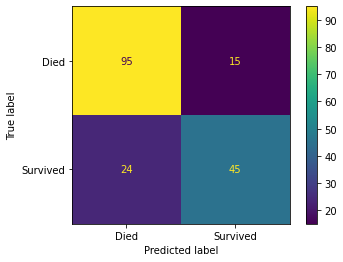

In [60]:
ConfusionMatrixDisplay.from_estimator(clf_xgb, X_val, y_val, display_labels=["Died", "Survived"])

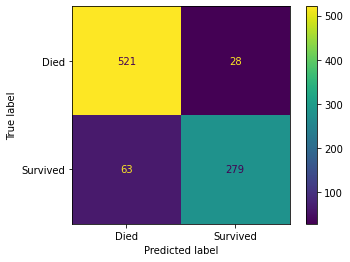

In [61]:
ConfusionMatrixDisplay.from_estimator(clf_xgb, X_encoded, y, display_labels=["Died", "Survived"])

In [70]:
predictions = clf_xgb.predict(Test_encoded)
predictions = pd.DataFrame(predictions)

output = test["PassengerId"].copy()

result = pd.DataFrame(clf_xgb.predict(Test_encoded), columns=["Survived"])

output = pd.concat([output, result], axis=1)

output.to_csv("submission668.csv", index=False)